In [3]:
import pickle
import copy
import numpy as np
import g2o
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("..")
from mapper.geometry import from_twist, to_twist

np.random.seed(0)

In [4]:
camera_matrix = pickle.load(open("camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
pose_graph = pickle.load(open("bundle_adjustment_experiments/pose_graph.pkl", "rb"))
map_points = pickle.load(open("bundle_adjustment_experiments/map_points.pkl", "rb"))

In [5]:
map_points.pts_3d, map_points.pts_3d.shape

(array([[ 5.54401205e-01, -6.42607911e-01,  1.19836006e+01],
        [ 8.74297667e-01, -2.72028489e+00,  1.56027363e+01],
        [ 1.47734440e+00, -5.56960867e-01,  1.17489116e+01],
        ...,
        [-5.55345074e+01, -4.52804213e-02, -2.77159047e-01],
        [-5.73449051e+01, -3.23201266e-01, -3.10992374e-01],
        [-5.72318589e+01,  1.87202583e-01, -5.20630683e-01]]),
 (30117, 3))

In [6]:
map_points_bak = np.copy(map_points.pts_3d)
print(map_points_bak)

[[ 5.54401205e-01 -6.42607911e-01  1.19836006e+01]
 [ 8.74297667e-01 -2.72028489e+00  1.56027363e+01]
 [ 1.47734440e+00 -5.56960867e-01  1.17489116e+01]
 ...
 [-5.55345074e+01 -4.52804213e-02 -2.77159047e-01]
 [-5.73449051e+01 -3.23201266e-01 -3.10992374e-01]
 [-5.72318589e+01  1.87202583e-01 -5.20630683e-01]]


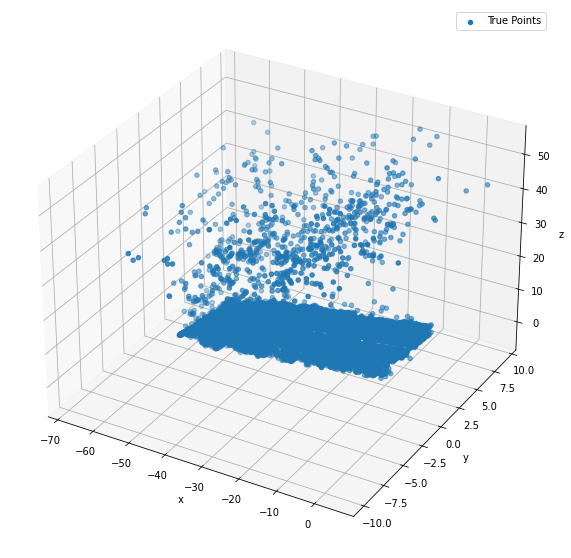

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(map_points.pts_3d[:, 0], map_points.pts_3d[:, 1], map_points.pts_3d[:, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend(["True Points", "Before Optimization", "After Optimization"])
plt.show()

In [7]:
nodes = list(sorted(pose_graph.nodes))[:5]
for node_id in nodes:
    print(node_id)
    R, t = from_twist(pose_graph.nodes[node_id]["pose"])
    print(R, t)

0
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.]
 [0.]
 [0.]]
1
[[ 0.9999644   0.00130517  0.00833638]
 [-0.00133224  0.99999385  0.00324276]
 [-0.0083321  -0.00325375  0.99995999]] [[-0.81459149]
 [-0.09094632]
 [-0.57286078]]
2
[[ 0.99959704  0.00445658  0.02803399]
 [-0.00597572  0.99850455  0.05434118]
 [-0.02774989 -0.05448681  0.99812882]] [[-1.87902921]
 [ 0.00277792]
 [-1.31507476]]
3
[[ 9.99791215e-01 -1.87176649e-03  2.03475330e-02]
 [ 5.23737968e-04  9.97815868e-01  6.60546754e-02]
 [-2.04267302e-02 -6.60302274e-02  9.97608519e-01]] [[-2.86145904]
 [ 0.18921158]
 [-1.54303774]]
4
[[ 0.99992826 -0.00558123  0.01059788]
 [ 0.00498569  0.99845109  0.05541268]
 [-0.01089074 -0.05535586  0.99840729]] [[-3.83868587]
 [-0.02701206]
 [-1.51725252]]


In [7]:
###################################################################
#
# local bundle adjustment
#
###################################################################

## setup optimizer and camera parameters
robust_kernel = True
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverCholmodSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

focal_length = (camera_matrix[0,0] + camera_matrix[1,1]) / 2
principal_point = (camera_matrix[0,2], camera_matrix[1,2])
print("focal_length: ", focal_length, "principal_point: ", principal_point)
cam = g2o.CameraParameters(focal_length, principal_point, 0)
cam.set_id(0)
optimizer.add_parameter(cam)

focal_length:  1121.8716561940905 principal_point:  (321.2278456933972, 265.04827021019815)


True

In [8]:
# add current keyframe poses
true_poses = []
nodes = list(sorted(pose_graph.nodes))[5:10]
for i, node_id in enumerate(nodes):
    print("Using keyframe {} for local BA".format(node_id))
    R, t = from_twist(pose_graph.nodes[node_id]["pose"])
    pose = g2o.SE3Quat(R, np.squeeze(t))
    true_poses.append(pose)

    v_se3 = g2o.VertexSE3Expmap()
    v_se3.set_id(node_id)
    v_se3.set_estimate(pose)
    if node_id < 2:
        v_se3.set_fixed(True)
    optimizer.add_vertex(v_se3)

# add map points
point_id = len(pose_graph) #len(true_poses)
inliers = dict()
for i, (point, observing_keyframes, associated_kp_indices) in enumerate(zip(map_points.pts_3d, map_points.observing_keyframes, map_points.associated_kp_indices)):    
    
    # skip points not visible in the selected subset of key frames
    if (observing_keyframes[0] not in nodes) or (observing_keyframes[1] not in nodes):
        continue

    vp = g2o.VertexSBAPointXYZ()
    vp.set_id(point_id)
    vp.set_marginalized(True)
    vp.set_estimate(point)
    optimizer.add_vertex(vp)

    # TODO:
    # 1) retrieve all key frames in which this map point is visible
    # 2) retrieve pixel coordinates of the keypoint corresponding to this map point in each key frame from 1)
    # 3) add an edge for each observation of the map point as below    
    for node_id, kp_idx in zip(observing_keyframes, associated_kp_indices):
        #if node_id not in nodes:
        #    continue
        kp = pose_graph.nodes[node_id]["kp"]
        measurement = kp[kp_idx]
        #print(i, point_id, node_id, measurement)
        
        edge = g2o.EdgeProjectXYZ2UV()
        edge.set_vertex(0, vp)  # map point
        edge.set_vertex(1, optimizer.vertex(node_id))  # pose of observing keyframe
        edge.set_measurement(measurement)   # needs to be set to the keypoint pixel position corresponding to that map point in that key frame (pose)
        edge.set_information(np.identity(2))
        if robust_kernel:
            #edge.set_robust_kernel(g2o.RobustKernelHuber())
            edge.set_robust_kernel(g2o.RobustKernelHuber(np.sqrt(5.991)))  # 95% CI

        edge.set_parameter_id(0, 0)
        optimizer.add_edge(edge)

    inliers[point_id] = i
    point_id += 1

print('num vertices:', len(optimizer.vertices()))
print('num edges:', len(optimizer.edges()))

Using keyframe 5 for local BA
Using keyframe 6 for local BA
Using keyframe 7 for local BA
Using keyframe 8 for local BA
Using keyframe 9 for local BA
num vertices: 1539
num edges: 3068


In [9]:
print('Performing full BA:')
optimizer.initialize_optimization()
optimizer.set_verbose(True)
optimizer.optimize(10)

poses_optimized = []
map_points_optimized = np.copy(map_points.pts_3d)

# read out optimized poses
for node_id in nodes:
    print(node_id)
    vp = optimizer.vertex(node_id)
    se3quat = vp.estimate()
    R = np.copy(se3quat.to_homogeneous_matrix()[0:3, 0:3])
    t = np.copy(se3quat.to_homogeneous_matrix()[0:3, 3])
    print(R, t)
    poses_optimized.append(to_twist(R, t))

# read out optimized map points
for point_id, i in inliers.items():
    vp = optimizer.vertex(point_id)
    map_points_optimized[i, :] = np.copy(vp.estimate())    

Performing full BA:
5
[[ 7.86036783e-01  9.70202953e-04  6.18178966e-01]
 [ 1.00601325e-02  9.99846265e-01 -1.43610321e-02]
 [-6.18097864e-01  1.75072618e-02  7.85906182e-01]] [-4.78925323 -0.01216559  1.96983883]
6
[[ 0.99867352  0.02834165  0.04298777]
 [-0.02763846  0.9994757  -0.01686512]
 [-0.04344322  0.01565464  0.99893324]] [-5.84576413  0.18697515 -1.19059023]
7
[[ 0.99840095  0.00888718  0.05582611]
 [-0.00977069  0.99983099  0.01557321]
 [-0.05567827 -0.01609377  0.99831905]] [-6.62220458  0.05652994 -1.10305833]
8
[[ 0.99980466  0.00784333  0.018142  ]
 [-0.00897374  0.99796744  0.0630909 ]
 [-0.01761028 -0.06324138  0.99784288]] [-7.56923049e+00 -7.34026827e-04 -1.39041150e+00]
9
[[ 0.9999028  -0.00317146  0.01357721]
 [ 0.00310208  0.99998204  0.00512829]
 [-0.01359323 -0.00508568  0.99989467]] [-8.84267997 -0.01817509 -1.15999186]


In [10]:
np.linalg.norm(map_points_optimized - map_points_bak, axis=0)

array([0.08245919, 0.26200606, 2.81706264])

In [11]:
map_points_optimized, map_points_bak

(array([[ 5.54401205e-01, -6.42607911e-01,  1.19836006e+01],
        [ 8.74297667e-01, -2.72028489e+00,  1.56027363e+01],
        [ 1.47734440e+00, -5.56960867e-01,  1.17489116e+01],
        ...,
        [-5.55345074e+01, -4.52804213e-02, -2.77159047e-01],
        [-5.73449051e+01, -3.23201266e-01, -3.10992374e-01],
        [-5.72318589e+01,  1.87202583e-01, -5.20630683e-01]]),
 array([[ 5.54401205e-01, -6.42607911e-01,  1.19836006e+01],
        [ 8.74297667e-01, -2.72028489e+00,  1.56027363e+01],
        [ 1.47734440e+00, -5.56960867e-01,  1.17489116e+01],
        ...,
        [-5.55345074e+01, -4.52804213e-02, -2.77159047e-01],
        [-5.73449051e+01, -3.23201266e-01, -3.10992374e-01],
        [-5.72318589e+01,  1.87202583e-01, -5.20630683e-01]]))

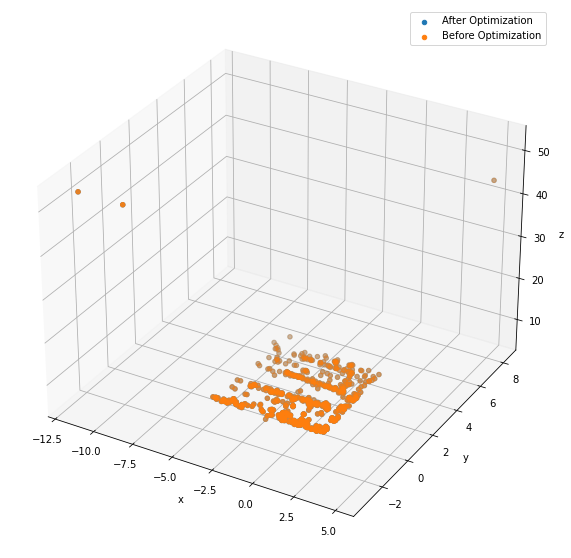

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(map_points_optimized[:500, 0], map_points_optimized[:500, 1], map_points_optimized[:500, 2])
ax.scatter(map_points_bak[:500, 0], map_points_bak[:500, 1], map_points_bak[:500, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend(["After Optimization", "Before Optimization", ])
plt.show()

### Local BA with automatic determination of visibility of map points

Map points are prjected in each keyframe based on the keyframe pose and visibility of the map point in the respective keyframe is determined.

PROBLEM: We do not have the corresponding keypoint pixel coordinates in all frames. Solution: Perform data association in odometry and build a covisibility graph.